# Equação da Difusão 1D

Vamos resolver numericamente a equação da difusão a 1D:

\begin{align*}
\frac{\partial u}{\partial t} = D\frac{\partial^2u}{\partial x^2}
\end{align*}

# Imports

In [1]:
# Importar as bibliotecas que vamos usar
import numpy as np
import scipy as sp

import matplotlib.pyplot as plt
from matplotlib import animation
from matplotlib.animation import PillowWriter

from PIL import Image
from typing import Callable

# Método FTCS

In [2]:
def dif1DFTCS(T: float, ci: np.ndarray, mask: np.ndarray, D: float, dx: float, dtMult: float = 0.99) -> tuple[np.ndarray, float]:
    """
        Resolve a equação da difusão de forma aproximada usando o método FTCS, assumindo que os pontos na fronteira do domínio têm valor fixo!

        :param T: float, Tempo para evoluir a equação
        :param ci: np.ndarray, array com as condições iniciais
        :param mask: np.ndarray, evolui apenas os pontos onde `mask == True`
        :param D: float, coeficinte de difusão
        :param dx: float, espaçamento entre pontos no eixo dos xx
        :param dtMult: float, o intervalo de tempo usado é `dtMult` * (menor dt para o qual o método é estável)

        :return: tuple containing:
            - np.ndarray, vetor solução
            - float, tempo decorrido
    """

    # Copiar condições iniciais
    now = np.copy(ci)
    nex = np.copy(ci)

    # Criar o passo no tempo
    dt = dx**2 / (2 * D) * dtMult
    iMax = T // dt + 1

    # Calcular números de Fourier
    Fx = D * dt / (dx**2)

    # Evoluir no tempo
    i = 0
    while i < iMax:
        # Passo FTCS
        nex[1:-1] = now[1:-1] + mask[1:-1] * (Fx * (now[2:] + now[:-2] - 2 * now[1:-1]))
        
        # Avançar para a próxima iteração
        i += 1
        now = np.copy(nex)
    
    return now, i * dt

# Método BTCS

In [3]:
def dif1DBTCS(T: float, ci: np.ndarray, mask: np.ndarray, D: float, dx: float, dt: float) -> tuple[np.ndarray, float]:
    """
        Resolve a equação da difusão de forma aproximada usando o método BTCS, assumindo que os pontos na fronteira do domínio têm valor fixo!

        :param T: float, Tempo para evoluir a equação
        :param ci: np.ndarray, matriz com as condições iniciais
        :param mask: np.ndarray, evolui apenas os pontos onde `mask == True`
        :param D: float, coeficinte de difusão
        :param dx: float, espaçamento entre pontos no eixo dos xx
        :param dt: float, intervalo de tempo usado

        :return: tuple containing:
            - np.ndarray, vetor solução
            - float, tempo decorrido
    """

    # Copiar condições iniciais
    Nx = ci.shape[0]
    now = np.copy(ci)
    nex = np.copy(ci)

    # Número máximo de iterações
    iMax = T // dt + 1

    # Calcular números de Fourier
    Fx = D * dt / (dx**2)

    # Construir a matriz de coeficientes
    aa = sp.sparse.diags_array([(1 + 2 * Fx), -Fx, -Fx], offsets=[0, -1, 1], shape=(Nx, Nx))

    # Aplicar máscara
    aa = sp.sparse.lil_matrix(aa)
    for i, item in enumerate(mask):
        if not item:
            aa[i, (i-1) % Nx] = 0
            aa[i, i] = 1
            aa[i, (i+1) % Nx] = 0

    
    # Pré-fatorizar a matriz de coeficientes
    aa = sp.sparse.csc_matrix(aa)
    aaSolver = sp.sparse.linalg.factorized(aa)

    # Evoluir no tempo
    i = 0
    while i < iMax:
        # Passo BTCS
        nex = aaSolver(now)
            
        # Avançar para a próxima iteração
        i += 1
        now = np.copy(nex)
    
    return now, i * dt

# Método CN

In [4]:
def dif1DCN(T: float, ci: np.ndarray, mask: np.ndarray, D: float, dx: float, dt: float) -> tuple[np.ndarray, float]:
    """
        Resolve a equação da difusão de forma aproximada usando o método de Crank-Nicholson, assumindo que os pontos na fronteira do domínio têm valor fixo!

        :param T: float, Tempo para evoluir a equação
        :param ci: np.ndarray, matriz com as condições iniciais
        :param mask: np.ndarray, evolui apenas os pontos onde `mask == True`
        :param D: float, coeficinte de difusão
        :param dx: float, espaçamento entre pontos no eixo dos xx
        :param dt: float, intervalo de tempo usado

        :return: tuple containing:
            - np.ndarray, vetor solução
            - float, tempo decorrido
    """

    # Copiar condições iniciais
    Nx = ci.shape[0]
    now = np.copy(ci)
    nex = np.copy(ci)

    # Número máximo de iterações
    iMax = T // dt + 1

    # Calcular números de Fourier
    Fx = D * dt / (dx**2)

    # Construir a matriz de coeficientes A
    aa = sp.sparse.diags_array([1 + Fx, -Fx/2, -Fx/2], offsets=[0, -1, 1], shape=(Nx, Nx))

    # Aplicar máscara
    aa = sp.sparse.lil_matrix(aa)
    for i, item in enumerate(mask):
        if not item:
            aa[i, (i-1) % Nx] = 0
            aa[i, i] = 1
            aa[i, (i+1) % Nx] = 0
    
    # Pré-fatorizar a matriz de coeficientes
    aa = sp.sparse.csc_matrix(aa)
    aaSolver = sp.sparse.linalg.factorized(aa)

    # Construir a matriz que permite obter o vetor do lado direito B
    bb = sp.sparse.diags_array([1 - Fx, Fx/2, Fx/2], offsets=[0, -1, 1], shape=(Nx, Nx))

    # Aplicar máscara
    bb = sp.sparse.lil_matrix(bb)
    for i, item in enumerate(mask):
        if not item:
            bb[i, (i-1) % Nx] = 0
            bb[i, i] = 1
            bb[i, (i+1) % Nx] = 0
    
    # Evoluir no tempo
    i = 0
    while i < iMax:
        nex = aaSolver(bb @ now)
            
        i += 1
        now = np.copy(nex)
    
    return now, i * dt

# Testar

## Caso 1

Vamos considerar a função:

$$
u(x, t) = \sin\left(2\pi \frac{x}{L_x}\right)\exp\left[-t\left(\frac{2\pi}{L_x}\right)^2 \right]
$$

Temos que:
$$
\nabla^2u = -\left(\frac{2\pi}{L_x}\right)^2u(x, t) = \frac{\partial u}{\partial t}
$$

Podemos então resolver a equação do calor com condição inicial dada por $u(x, y, 0)$ e condição fronteira $u = 0$ em todo o bordo e comparar com a solução analítica!

In [5]:
# Criar o problema
Lx = 1

# Parâmetros
Nx = 151

Nt = 2001
Tmax = 0.1

dx = Lx / (Nx - 1)
dt = Tmax / (Nt - 1)

ci = np.zeros(Nx)
mask = np.full(Nx, True)

# Condições do problema (a fronteira é só a borda da caixa)
for i in range(Nx):
    if i in [0, Nx-1]:
        mask[i] = False


A = 10000
i = 1
def u(x, t):
    return A * np.sin(i * 2*np.pi * x / Lx) * np.exp(-t * (i * 2*np.pi / Lx)**2)


xx = np.linspace(0, Lx, Nx)
ci = u(xx, 0)

### Método FTCS

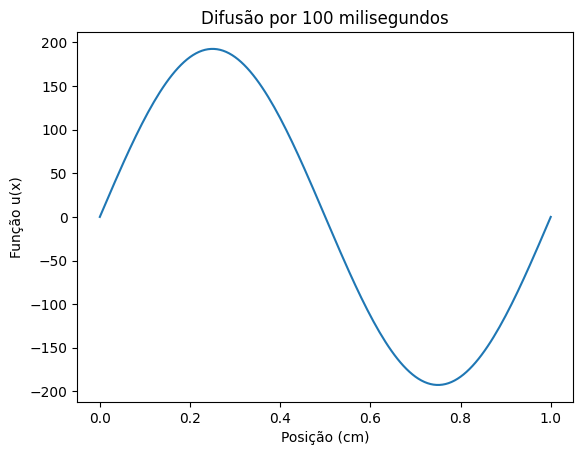

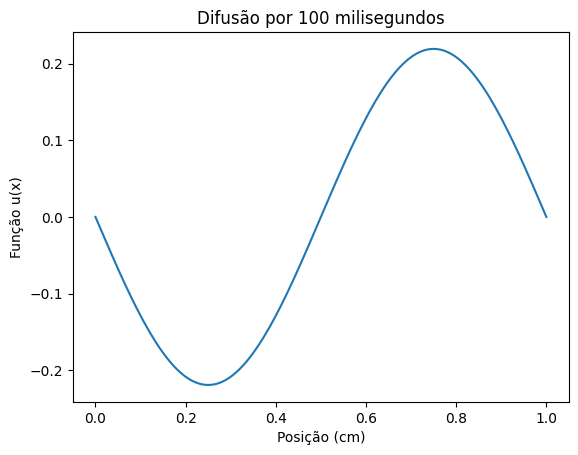

In [6]:
# Fazer a simulação
sol, tem = dif1DFTCS(Tmax, ci, mask, 1, dx)


# Mostrar a solução
plt.plot(xx, sol, label="Resultado")
plt.title(f"Difusão por {tem*1000:.0f} milisegundos")
plt.xlabel('Posição (cm)')
plt.ylabel('Função u(x)')
plt.show()

# Comparar com a solução exata
plt.plot(xx, sol - u(xx, tem), label="Resultado")
plt.title(f"Difusão por {tem*1000:.0f} milisegundos")
plt.xlabel('Posição (cm)')
plt.ylabel('Função u(x)')
plt.show()

### Método BTCS

In [7]:
# Fazer a simulação
sol, tem = dif1DBTCS(Tmax, ci, mask, 1, dx, dt)


# Mostrar a solução
plt.plot(xx, sol, label="Resultado")
plt.title(f"Difusão por {tem*1000:.0f} milisegundos")
plt.xlabel('Posição (cm)')
plt.ylabel('Função u(x)')
plt.show()

# Comparar com a solução exata
plt.plot(xx, sol - u(xx, tem), label="Resultado")
plt.title(f"Difusão por {tem*1000:.0f} milisegundos")
plt.xlabel('Posição (cm)')
plt.ylabel('Função u(x)')
plt.show()

AttributeError: module 'scipy.sparse' has no attribute 'diags_array'

### Método CN

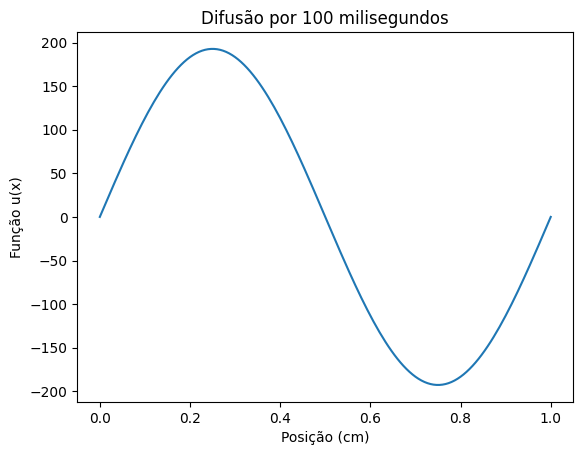

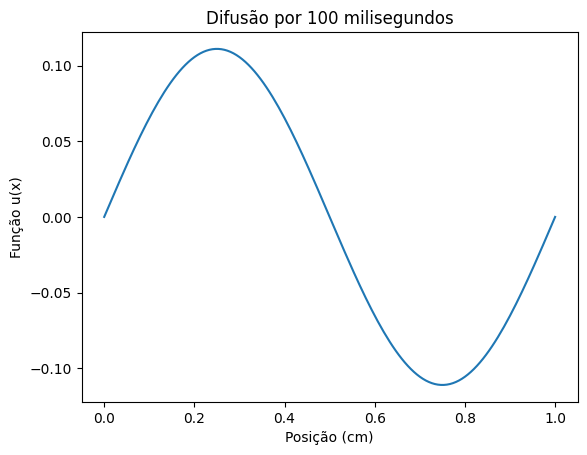

In [ ]:
# Fazer a simulação
sol, tem = dif1DCN(Tmax, ci, mask, 1, dx, dt)


# Mostrar a solução
plt.plot(xx, sol, label="Resultado")
plt.title(f"Difusão por {tem*1000:.0f} milisegundos")
plt.xlabel('Posição (cm)')
plt.ylabel('Função u(x)')
plt.show()

# Comparar com a solução exata
plt.plot(xx, sol - u(xx, tem), label="Resultado")
plt.title(f"Difusão por {tem*1000:.0f} milisegundos")
plt.xlabel('Posição (cm)')
plt.ylabel('Função u(x)')
plt.show()